In [1]:
import torch
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import HyperModel, Hyperband
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model as load_keras_model

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 194 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [5]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.models.Sequential()
        model.add(
            Conv2D(
                filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_1_kernel_size', values=[3, 5]),
                activation='relu',
                input_shape=self.input_shape
        ))
        model.add(MaxPooling2D(2, 2))
        model.add(
            Conv2D(
                filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=16),
                kernel_size=hp.Choice('conv_2_kernel_size', values=[3, 5]),
                activation='relu'
        ))
        model.add(MaxPooling2D(2, 2))
        model.add(
            Conv2D(
                filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=16),
                kernel_size=hp.Choice('conv_3_kernel_size', values=[3, 5]),
                activation='relu'
        ))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(
            Dense(
                hp.Int('dense_units', min_value=128, max_value=512, step=32),
                activation='relu'
        ))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(
            Dense(1, activation='sigmoid')
        )
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [6]:
number_of_epochs = 30

In [7]:
hypermodel = CNNHyperModel(input_shape=(64, 64, 3))

In [8]:
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyper_parameter_tuning_CNN',
    project_name='mushroom_classification'
)

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
tuner.search(
    train_generator,
    epochs=number_of_epochs,
    validation_data=val_generator
)

Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.5714285969734192

Best val_accuracy So Far: 0.5714285969734192
Total elapsed time: 00h 12m 16s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 96)     │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 112)    │        96,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 416)    │       419,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 416)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,917,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,457,617 (9.38 MB)

 Trainable params: 2,457,617 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the best model
history = model.fit(
    train_generator,
    epochs=number_of_epochs,
    validation_data=val_generator
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.5513 - loss: 3.4037 - val_accuracy: 0.4286 - val_loss: 1.4504
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5134 - loss: 0.9723 - val_accuracy: 0.4286 - val_loss: 0.6949
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5605 - loss: 0.6899 - val_accuracy: 0.4286 - val_loss: 0.7045
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5491 - loss: 0.6897 - val_accuracy: 0.4286 - val_loss: 0.7291
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5789 - loss: 0.6789 - val_accuracy: 0.4286 - val_loss: 0.7315
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.6007 - loss: 0.6731 - val_accuracy: 0.4286 - val_loss: 0.7217
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5772 - loss: 0.6883 - val_accuracy: 0.4286 - val_loss: 0.7204
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5809 - loss: 0.6844 - val_accuracy: 0.4286 - val_loss:

In [12]:
loss, accuracy = model.evaluate(val_generator)
print(f"Final validation accuracy: {accuracy*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step - accuracy: 0.4286 - loss: 0.7204
Final validation accuracy: 42.86%


In [13]:
# Save the model, optional
model.save(f'Pth_Files/CNN_TensorFlow_{number_of_epochs}.keras')

## Results

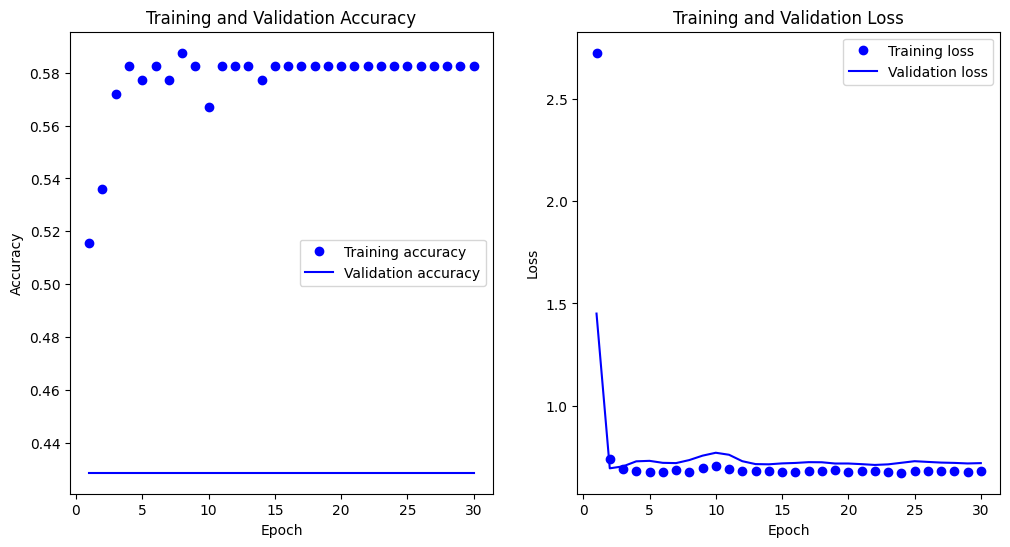

In [14]:
# Plot training & validation accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        linewidths=.5,
        square=True,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix CNN Tensorflow Model', size=15)
    plt.show()

def load_model(file_path):
    extension = os.path.splitext(file_path)[1]
    if extension == '.pth':
        model = torch.load(file_path)
        model.eval()
        return model
    elif extension == '.keras':
        return load_keras_model(file_path)
    else:
        raise ValueError("Unsupported file extension: {}".format(extension))

def model_stats(model_file):
    model = load_model(model_file)
    predictions = []

    if isinstance(model, torch.nn.Module):
        model.eval()
        with torch.no_grad():
            for images, _ in val_generator:
                images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(images)
                probabilities = torch.sigmoid(outputs)
                predictions.extend(probabilities.cpu().numpy().flatten())
    else:
        predictions = model.predict(val_generator, steps=len(val_generator)).ravel()

    y_pred = (predictions > 0.5).astype(int)
    y_true = val_generator.classes

    # Classification report as a dictionary
    report = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys(), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(val_generator.class_indices.keys())
    plot_confusion_matrix(cm, class_names)
    print(report_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


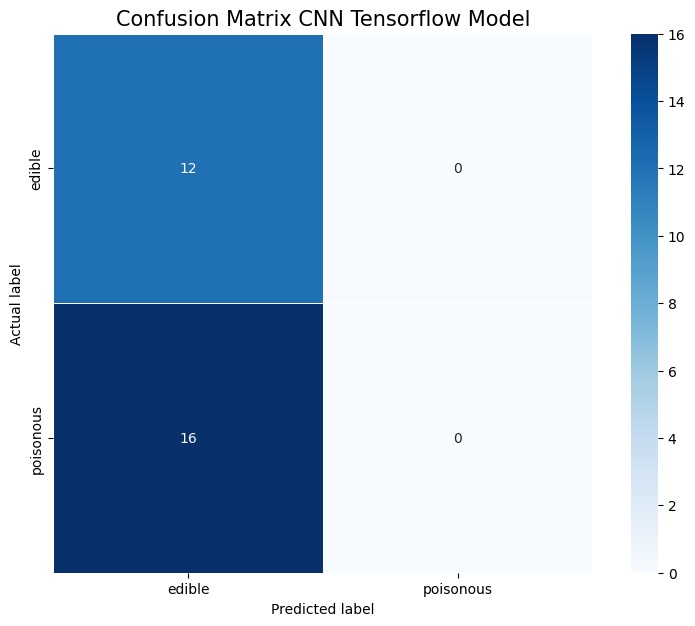

              precision    recall  f1-score    support
edible         0.428571  1.000000  0.600000  12.000000
poisonous      0.000000  0.000000  0.000000  16.000000
accuracy       0.428571  0.428571  0.428571   0.428571
macro avg      0.214286  0.500000  0.300000  28.000000
weighted avg   0.183673  0.428571  0.257143  28.000000


In [16]:
model_stats(f'Pth_Files/CNN_TensorFlow_{number_of_epochs}.keras')